In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_add_pool
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from statistics import mean
import uproot

In [2]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

In [5]:
# Read the ROOT file
tree = uproot.open("Dijet_bb_pt20_50_dw.root" + ":" + path_to_tree)
bb_df = tree.arrays(tree.keys(), library="pd")#, entry_start=0, entry_stop=600000) #1000-2000 events read in

# Clean column names and remove unwanted columns
bb_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb_df.columns]
rename_columns(bb_df)
columns_to_remove = [col for col in bb_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb_df.drop(columns=columns_to_remove, inplace=True)
for col in bb_df.columns:
    if "SVtag" in col:
        bb_df[col] = bb_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_cc_pt20_50_dw.root" + ":" + path_to_tree)
cc_df = tree.arrays(tree.keys(), library="pd")#, entry_start=0, entry_stop=600000) #1000-2000 events read in

# Clean column names and remove unwanted columns
cc_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in cc_df.columns]
rename_columns(cc_df)
columns_to_remove = [col for col in cc_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
cc_df.drop(columns=columns_to_remove, inplace=True)
for col in cc_df.columns:
    if "SVtag" in col:
        cc_df[col] = cc_df[col].apply(extract_float)
tree.close()
#13 m full stats

/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [6]:
print(f'There are {len(cc_df)} c-jet events (signal)')

There are 1694797 c-jet events (signal)


In [7]:
print(f'There are {len(bb_df)} b-jet events (background)')

There are 1824752 b-jet events (background)


In [ ]:
# Read from csv and assign truth labels
sig_df = cc_df.assign(IsC=1)
bkg_df = bb_df.assign(IsC=0)

# Filter columns to include only leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsC")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsC")]]

# Apply cuts and truth matching
sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfD'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]

bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols
# 55 m

In [ ]:
# Separate signal and background data and assign truth labels
# Then apply Monte Carlo truth matching 

sig_df = cc_df.assign(IsC=1).loc[
    (cc_df['Jet0_MC_Match'] == 1) &
    (cc_df['Jet0_MC_Jet_EfD'] > 0.6) &
    (cc_df['Jet0_PT'] > 20000) &
    (cc_df['Jet0_Eta'].between(2.2, 4.4))
]

bkg_df = bb_df.assign(IsC=0).loc[
    (bb_df['Jet0_MC_Match'] == 1) &
    (bb_df['Jet0_MC_Jet_EfB'] > 0.6) &
    (bb_df['Jet0_PT'] > 20000) &
    (bb_df['Jet0_Eta'].between(2.2, 4.4))
]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)

In [ ]:
# Define feature columns including jet-level and daughter-level features
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

In [9]:
print(f"Efficiency of signal truth matching is: {len(sig_df)/len(cc_df):.6f}") # sig_df is after truth matching, and cc_df is all the c-jet events before
print(f"Efficiency of background truth matching is: {len(bkg_df)/len(bb_df):.6f}")
print(f"Total events after truth matching: {len(combined_df):.6f}")
print(f"Number of c-jets after truth matching: {sum(combined_df):.6f}")

Efficiency of signal truth matching is: 0.217626
Efficiency of background truth matching is: 0.345027


In [ ]:
# Prepare features by converting daughter information to lists and duplicating jet-level features
def prepare_features(df, jet_cols, daughter_cols):
    # Duplicate data to lists matching the number of daughters/nodes per jet/row
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row['Jet0_nDaughters'] if isinstance(row[col], (float, int)) else row[col], axis=1)

    # Convert string values into list of floats
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

df = prepare_features(combined_df, jet_cols, daughter_cols)

# Calculate sizes for training, testing, and validation sets per class
half_train_size = int((sum(df['IsC']) * 0.8) / 2)  # 80% for training, half per class
half_test_size = int((sum(df['IsC']) * 0.2) / 2)   # 20% for testing, half per class

# Training data: first portion for each class
train_df = pd.concat([sig_df.head(half_train_size), bkg_df.head(half_train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of training data is: {len(train_df)}')

# Testing data: last portion for each class
test_df = pd.concat([sig_df.tail(half_test_size), bkg_df.tail(half_test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of testing data is: {len(test_df)}')

# Validation data: middle portion not used in training or testing
validation_df = pd.concat([sig_df.iloc[half_train_size:-half_test_size], bkg_df.iloc[half_train_size:-half_test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of validation data is: {len(validation_df)}')

In [ ]:
# Check to see if there is overlap or duplicated events in different datasets
assert len(train_df) + len(test_df) + len(validation_df) == len(df), "Data split size mismatch!"
assert not train_df.duplicated().any(), "Duplicate rows found in training set!"
assert not test_df.duplicated().any(), "Duplicate rows found in testing set!"
assert not validation_df.duplicated().any(), "Duplicate rows found in validation set!"

In [32]:
# Create graphs for training and testing
def create_graphs(df, feature_cols):

    features_list = []
    
    for _, row in df.iterrows():
        num_nodes = row['Jet0_nDaughters']
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    data_objects = []
    for idx, features in enumerate(features_list):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        # Create fully connected graph
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsC'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Create graphs for training and testing
train_data = create_graphs(train_df, feature_cols)
test_data = create_graphs(test_df, feature_cols)

# Load data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [33]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = SAGEConv(len(feature_cols), hidden_channels)
        self.ln1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.ln2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.ln3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.ln4 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(0.3)

    def forward(self, x, edge_index, batch):        
        x = self.conv1(x, edge_index)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.ln4(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)
    
model = GNN()
model = model.to(device)

In [34]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5) # reduce lr by 0.5 every 5 epochs


# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    avg_loss = total_loss / len(train_loader.dataset)

    return avg_loss

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y.float())
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
            total_loss += loss.item() * data.num_graphs

        avg_loss = total_loss / len(loader.dataset)
        acc = total_correct / total_samples
    return avg_loss, acc

# Training parameters
num_epochs = 250

# Initialize lists for storing loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):

    train_loss = train()
    train_loss_values.append(train_loss)

    train_acc = test(train_loader)[1]
    train_acc_values.append(train_acc)

    test_loss, test_acc = test(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)

    scheduler.step(test_loss)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

torch.save(model.state_dict(), 'cb2_model.pth')
print('Model saved as fullrun_cb_model.pth. Training complete.')

results_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs+1)),
    'Train Loss': train_loss_values,
    'Test Loss': test_loss_values,
    'Train Accuracy': train_acc_values,
    'Test Accuracy': test_acc_values
})

# Save the loss and accuracy values to a CSV file
results_df.to_csv('fullrun_cb_training_results.csv', index=False)
# 62 m

Epoch: 001, Train Loss: 0.5817, Test Loss: 0.5084, Train Acc: 0.7487, Test Acc: 0.7471
Epoch: 002, Train Loss: 0.5081, Test Loss: 0.4928, Train Acc: 0.7570, Test Acc: 0.7550
Epoch: 003, Train Loss: 0.4924, Test Loss: 0.4773, Train Acc: 0.7649, Test Acc: 0.7651
Epoch: 004, Train Loss: 0.4841, Test Loss: 0.4769, Train Acc: 0.7649, Test Acc: 0.7628
Epoch: 005, Train Loss: 0.4788, Test Loss: 0.4681, Train Acc: 0.7719, Test Acc: 0.7706
Epoch: 006, Train Loss: 0.4750, Test Loss: 0.4677, Train Acc: 0.7711, Test Acc: 0.7704
Epoch: 007, Train Loss: 0.4723, Test Loss: 0.4642, Train Acc: 0.7745, Test Acc: 0.7726
Epoch: 008, Train Loss: 0.4695, Test Loss: 0.4619, Train Acc: 0.7748, Test Acc: 0.7726
Epoch: 009, Train Loss: 0.4673, Test Loss: 0.4582, Train Acc: 0.7760, Test Acc: 0.7739
Epoch: 010, Train Loss: 0.4658, Test Loss: 0.4582, Train Acc: 0.7764, Test Acc: 0.7744
Epoch: 011, Train Loss: 0.4642, Test Loss: 0.4592, Train Acc: 0.7758, Test Acc: 0.7739
Epoch: 012, Train Loss: 0.4624, Test Loss: 

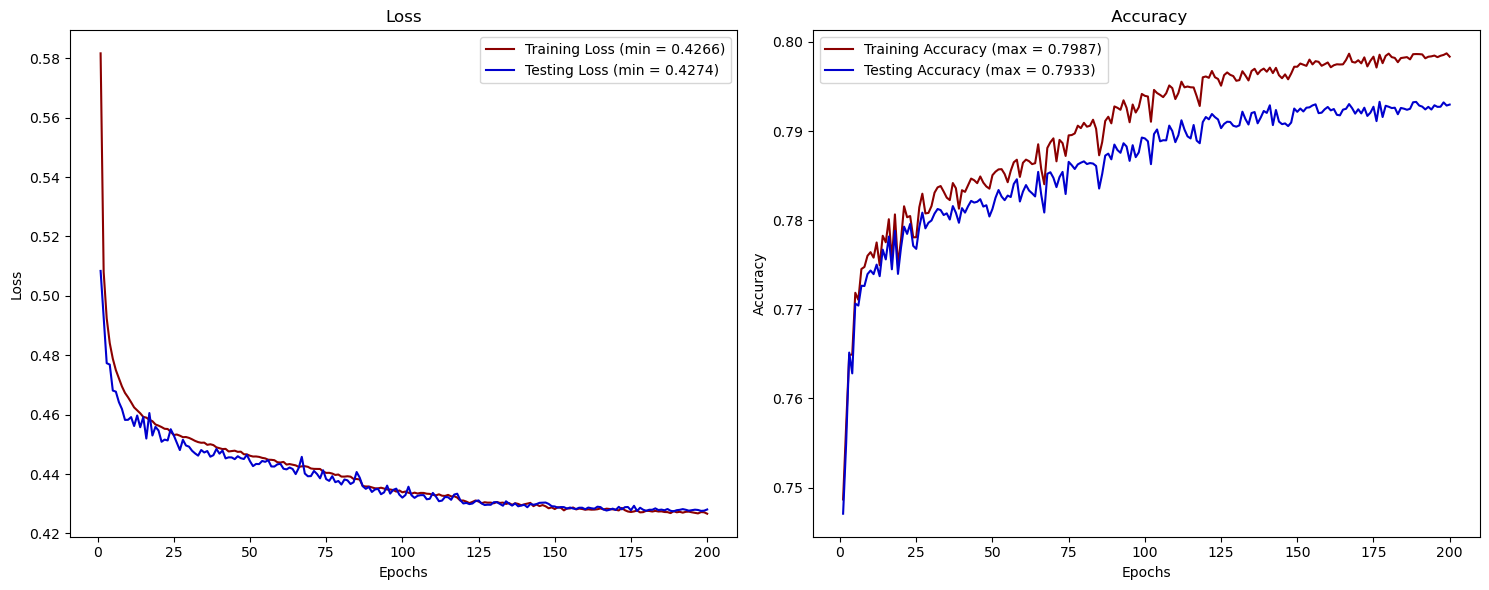

In [35]:
# Plot Loss and Accuracy
def plot_training_results():
    epochs = range(1, len(train_loss_values) + 1)

    mean_train_loss = mean(train_loss_values)
    mean_test_loss = mean(test_loss_values)
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)

    min_train_loss = min(train_loss_values)
    min_test_loss = min(test_loss_values)
    max_train_acc = max(train_acc_values)
    max_test_acc = max(test_acc_values)

    final_train_loss = train_loss_values[-1]
    final_test_loss = test_loss_values[-1]
    final_train_acc = train_acc_values[-1]
    final_test_acc = test_acc_values[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Loss
    ax1.plot(epochs, train_loss_values, color='darkred', label=(f"Training Loss (min = {min_train_loss:.4f})"))
    ax1.plot(epochs, test_loss_values, color='mediumblue', label=(f"Testing Loss (min = {min_test_loss:.4f})"))
    
    ax1.text(0.05, 0.95, "LHCb Simulation", transform=plt.gca().transAxes,fontsize=12, verticalalignment='top')
    
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (max = {max_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='mediumblue', label=(f"Testing Accuracy (max = {max_test_acc:.4f})"))
    
    ax2.text(0.05, 0.95, "LHCb Simulation", transform=plt.gca().transAxes,fontsize=12, verticalalignment='top')

    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.style.use('default')
    plt.tight_layout()
    plt.show()
    
plot_training_results()

In [1]:
#model.load_state_dict(torch.load('cb_model.pth'))
#model.eval()

In [36]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model = model.to('cpu')
model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

np.save('cb_roc_data.npy', np.array([fpr, tpr, thresholds, auc]))

/tmp/ipykernel_10083/3973963081.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('cb_roc_data.npy', np.array([fpr, tpr, thresholds, auc]))


In [37]:
desired_tpr = 0.8
closest_index = np.argmin(np.abs(tpr - desired_tpr))

# Retrieve the threshold and corresponding FPR for this TPR
chosen_threshold = thresholds[closest_index]
chosen_fpr = fpr[closest_index]

print(f"TPR {desired_tpr}: Pc {chosen_threshold:.4f}: FPR {chosen_fpr:.4f}")

TPR 0.8: Pb 0.5943: FPR 0.2230


In [46]:
# Get FPRs for TPRs
desired_tpr = [.2, .3, .4]

for val in desired_tpr:
    closest_index = np.argmin(np.abs(tpr - val))
    chosen_threshold = thresholds[closest_index]
    chosen_fpr = fpr[closest_index]
    print(f"{val}: {chosen_fpr:.4f}")

0.2: 0.0145
0.3: 0.0295
0.4: 0.0495


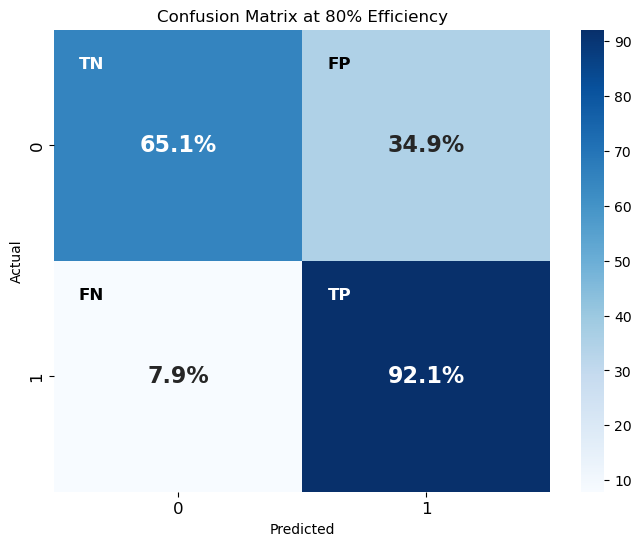

In [39]:
# need to revise for different efficiency

y_pred_binary = (y_scores >= 0.4183).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

cm_percentage = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

annot_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = cm_percentage[i, j]
        annot_labels[i, j] = f'{percentage:.1f}%'

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix at 80% Efficiency")

ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

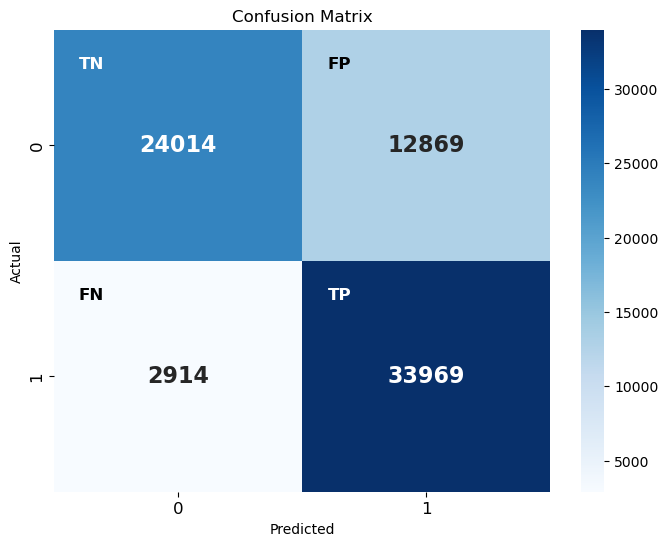

In [40]:
# need to revise for different efficiency
y_pred_binary = (y_scores >= 0.4183).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)
df_cm = pd.DataFrame(cm)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")

# Add TP, FP, FN, TN labels
ax.text(0.15, 0.15, 'TN', ha='center', va='center', fontweight='bold', fontsize=12, color='white')
ax.text(1.15, 0.15, 'FP', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(0.15, 1.15, 'FN', ha='center', va='center', fontweight='bold', fontsize=12)
ax.text(1.15, 1.15, 'TP', ha='center', va='center', fontweight='bold', fontsize=12, color='white')

plt.show()

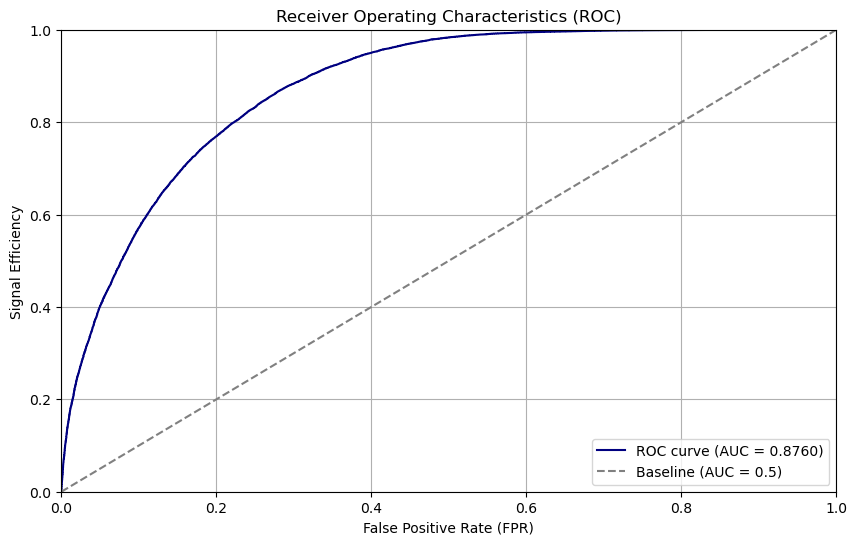

In [41]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.style.use('default')
plt.ylabel('Signal Efficiency')
plt.xlabel('False Positive Rate (FPR)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

                                Feature  Importance
0                      Jet0_Daughters_E    0.790261
1                     Jet0_Daughters_pT    1.200949
2                     Jet0_Daughters_ID    0.034269
3                     Jet0_Daughters_pX    0.055346
4                     Jet0_Daughters_pY    0.079302
5                     Jet0_Daughters_pZ    0.872470
6                    Jet0_Daughters_Eta    0.003432
7                    Jet0_Daughters_Phi    0.001535
8                      Jet0_Daughters_Q    0.000720
9                     Jet0_Daughters_IP    0.056755
10                Jet0_Daughters_IPCHI2    1.019533
11                 Jet0_Daughters_IPraw    0.022730
12                   Jet0_Daughters_NNe    0.112775
13                   Jet0_Daughters_NNk    0.184865
14                   Jet0_Daughters_NNp    0.125699
15                  Jet0_Daughters_NNpi    0.161307
16                  Jet0_Daughters_NNmu    0.917134
17                  Jet0_Daughters_Chi2    0.151865
18          

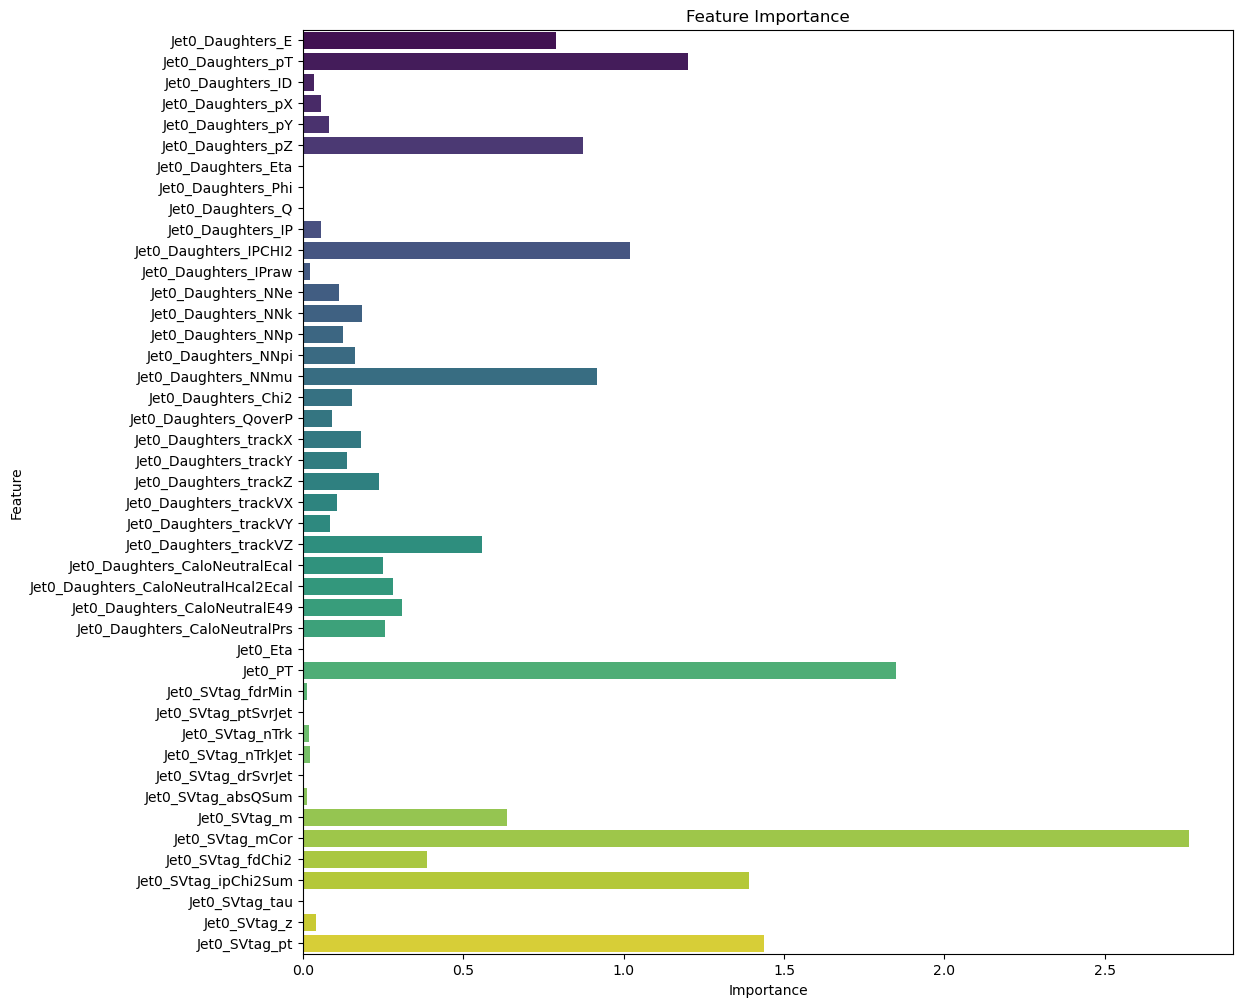

In [42]:
# Prepare model
model.eval()
data = next(iter(test_loader))
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

feature_importances = np.zeros(x.size(1))

for feature_idx in range(x.size(1)):
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Compute importance - difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred))
    feature_importances[feature_idx] = importance

importance_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feature_importances})
print(importance_df)

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [43]:
for index, row in importance_df.iterrows():
    feature = row['Feature'] 
    importance = row['Importance']
    if importance > 0.25:
        print(f'{feature} & {importance:4f}')

Jet0_Daughters_E & 0.790261
Jet0_Daughters_pT & 1.200949
Jet0_Daughters_pZ & 0.872470
Jet0_Daughters_IPCHI2 & 1.019533
Jet0_Daughters_NNmu & 0.917134
Jet0_Daughters_trackVZ & 0.558176
Jet0_Daughters_CaloNeutralHcal2Ecal & 0.279465
Jet0_Daughters_CaloNeutralE49 & 0.307001
Jet0_Daughters_CaloNeutralPrs & 0.254001
Jet0_PT & 1.848399
Jet0_SVtag_m & 0.634932
Jet0_SVtag_mCor & 2.762828
Jet0_SVtag_fdChi2 & 0.386202
Jet0_SVtag_ipChi2Sum & 1.390848
Jet0_SVtag_pt & 1.436983


# Model Probability Output

In [ ]:
df = full_df

def make_predictions():
    # Select a random integer for sampling
    random_integer = np.random.randint(0, len(df))
    sample_jet = df.iloc[random_integer:random_integer+1].copy()

    # Filter columns related to Jet0
    sample_jet = sample_jet.filter(like='Jet0')

    # Define feature columns
    daughter_cols = [col for col in sample_jet.columns if "_Daughters" in col]
    svtag_cols = ['Jet0_SVtag_fdrMin',
    'Jet0_SVtag_ptSvrJet',
    'Jet0_SVtag_nTrk',
    'Jet0_SVtag_nTrkJet',
    'Jet0_SVtag_drSvrJet',
    'Jet0_SVtag_absQSum',
    'Jet0_SVtag_m',
    'Jet0_SVtag_mCor',
    'Jet0_SVtag_fdChi2',
    'Jet0_SVtag_ipChi2Sum',
    'Jet0_SVtag_tau',
    'Jet0_SVtag_z',
    'Jet0_SVtag_pt']
    jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
    feature_cols = daughter_cols + jet_cols

    # Process feature columns
    for col in feature_cols:
        if col in sample_jet.columns:
            sample_jet[col] = sample_jet.apply(lambda row: [row[col]] * int(row['Jet0_nDaughters']) if isinstance(row[col], (float, int)) else row[col], axis=1)
            sample_jet[col] = sample_jet[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

    # Obtain features of each node within the graph
    features_list = []
    for _, row in sample_jet.iterrows():
        num_nodes = int(row['Jet0_nDaughters'])
        jet_nodes = [[] for _ in range(num_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(num_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    # Create graph representation with data objects
    data_objects = []
    for features in features_list:
        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        data = Data(x=x, edge_index=edge_index)
        data_objects.append(data)

    jet_input = data_objects

    for data in jet_input:
        with torch.no_grad():
            output = model(data.x, data.edge_index, data.batch)
            probability = torch.sigmoid(output)
            prediction = (probability > 0.43696803).int()

    print(f'Probability: {probability.item()}')
    if prediction.item() == 1:  
        print(f'Prediction: b-jet')
    if prediction.item() == 0:  
        print(f'Prediction: not a b-jet')
    return probability.item()

i = 0

for i in range(100):
    cprob = make_predictions()
    bprob = make_predictions()

In [ ]:
# Separate b and q data from testing dataset (preprocessed)
c = validation_df[validation_df.IsC == 1]
b = validation_df[validation_df.IsC == 0]

c_data = create_graphs(c, feature_cols)
b_data = create_graphs(b, feature_cols)

c_prob = []
b_prob = []

model.eval()
with torch.no_grad():
    for data in c_data:
        out = model(data.x, data.edge_index, data.batch)
        cprob = torch.sigmoid(out)
        c_prob.append(cprob.numpy().flatten())
    for data in b_data:
        out = model(data.x, data.edge_index, data.batch)
        bprob = torch.sigmoid(out)
        b_prob.append(bprob.numpy().flatten())

c_prob = np.concatenate(c_prob)
b_prob = np.concatenate(b_prob)

In [ ]:
c_values, c_bins, _ = plt.hist(c_prob, bins=100, label='c-jets', color='darkred', histtype='step');
b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='b-jets', color='mediumblue', histtype='step');

In [ ]:
# Find the cutoff for desired efficiency (sum under Pb)
c_bin_area = np.cumsum(np.diff(c_bins) * c_values)
sum(c_bin_area[:64])/sum(c_bin_area)

In [ ]:
eighty_eff = c_bins[47]
print(eighty_eff)
seventy_eff = c_bins[56]
print(seventy_eff)
sixty_eff = c_bins[64]
print(sixty_eff)

In [ ]:
plt.figure(figsize=(10, 6))
c_values, c_bins, _ = plt.hist(c_prob, bins=100, label='b-jets', color='darkred', histtype='step')
b_values, b_bins, _ = plt.hist(b_prob, bins=100, label='q-jets', color='mediumblue', histtype='step')
plt.vlines(x=eighty_eff, ymin=0, ymax=1000, color='grey', linestyle='--')
plt.text(eighty_eff, 1200, '80%', horizontalalignment='center', verticalalignment='center')

plt.vlines(x=seventy_eff, ymin=0, ymax=1000, color='grey', linestyle='--')
plt.text(seventy_eff, 1200, '70%', horizontalalignment='center', verticalalignment='center')

plt.vlines(x=sixty_eff, ymin=0, ymax=1000, color='grey', linestyle='--')
plt.text(sixty_eff, 1200, '60%', horizontalalignment='center', verticalalignment='center')

plt.yscale('log')
plt.xlim(0,1)
plt.ylim(0,1e4)
plt.ylabel('Number of jets')
plt.xlabel('P$_c$')
plt.legend(loc='best')
#plt.title('Probability Distribution')
plt.show()